# Traffic Sign Recognition Using Vision Transformers

This project is designed to leverage the capabilities of Vision Transformers for the classification of traffic signs from real-time video data. The project aims to build a model that can aid autonomous vehicles and driver assistance systems by quickly and accurately identifying traffic signs, contributing to safer and more informed driving decisions.

This project is inspired by the comprehensive work done on machine learning benchmarks for traffic sign recognition, as detailed by Stallkamp et al. (2012), which utilized the German Traffic Sign Recognition Benchmark (GTSRB) dataset. The GTSRB dataset has been instrumental in advancing the field of automated traffic sign recognition, providing a wide variety of sign images under different environmental conditions.
- The GTSRB contains 43 classes of traffic signs, split into 39,209 training images and 12,630 test images. The images have varying light conditions and rich backgrounds.
<br><br>

*Reference:
Stallkamp, J., Schlipsing, M., Salmen, J., & Igel, C. (2012). Man vs. computer: Benchmarking machine learning algorithms for traffic sign recognition. Neural Networks, 32, 323-332.*

## Environment Set Up

First let's make sure we have installed and loaded all needed packages.

In [ ]:
!pip install accelerate transformers datasets wandb

In [29]:
import tensorflow as tf
import transformers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import random
from PIL import Image, ImageDraw

## Data Overview
First, let's examine the main characteristics of the dataset, based on the information provided to us in the form of a CSV file. We can see the distribution of classes, widths, and heights. We need this information to understand the variability and balance within our dataset. By analyzing the distribution of classes, we can assess whether the dataset is imbalanced and if there's a need for techniques like resampling. Examining the widths and heights of the images will inform us about the diversity in image dimensions, guiding us in making decisions about image preprocessing steps such as resizing, cropping, or padding. This initial analysis is crucial for designing an effective pipeline for data processing and model training, ensuring that the model is trained on representative and well-prepared data.

In [2]:
import pandas as pd
columns_to_read = ['Width', 'Height', 'ClassId']
rename_columns = {
    'Width': 'width',
    'Height': 'height',
    'ClassId': 'label'
}

data = pd.read_csv('./Train.csv',  usecols=columns_to_read)
data = data.rename(columns=rename_columns)

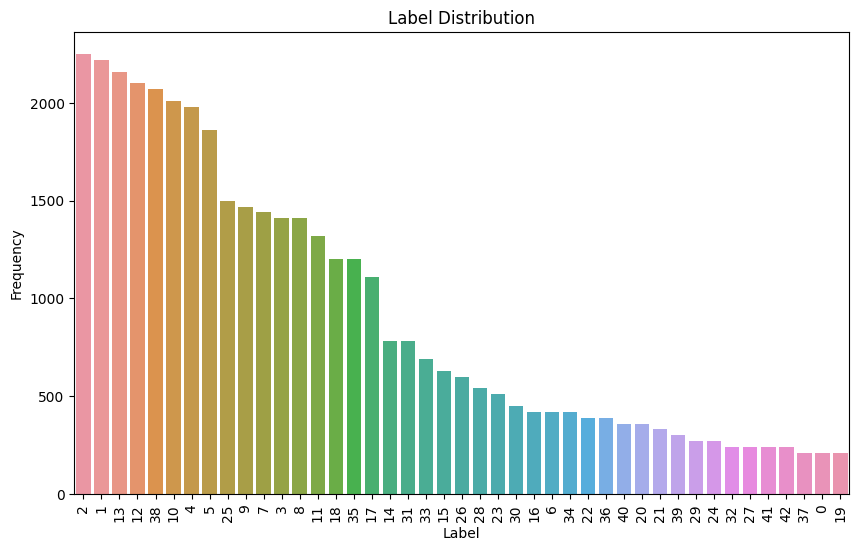

In [3]:
label_order = data['label'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=data, order=label_order)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

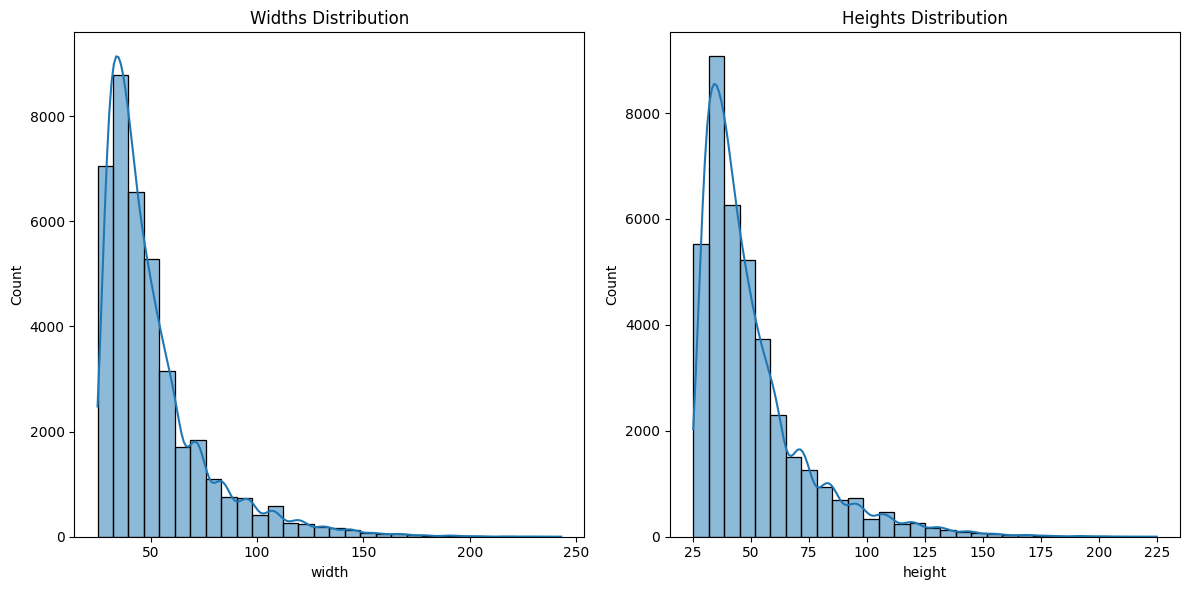

In [5]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data['width'], kde=True, bins=30)
plt.title('Widths Distribution')

plt.subplot(1, 2, 2)
sns.histplot(data['height'], kde=True, bins=30)
plt.title('Heights Distribution')

plt.tight_layout()
plt.show()

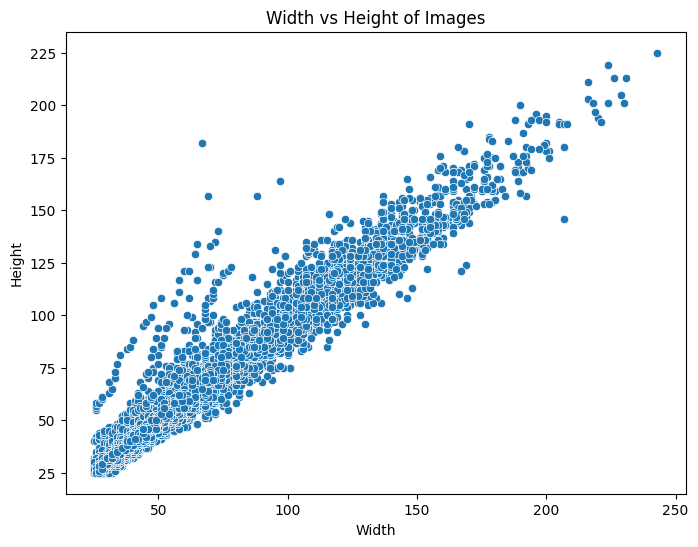

In [6]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='width', y='height', data=data)
plt.title('Width vs Height of Images')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

From the plots we can see The dataset exhibits a wide range of image dimensions, with a higher concentration of medium-sized images, as indicated by the dense central region in the scatter plot. The width and height distributions both skew right, suggesting a larger number of smaller images. The label distribution is imbalanced, with some classes significantly more represented than others, which could impact the performance of classification models trained on this data.

## Data Preprocessing

In [14]:
from datasets import DatasetDict, load_dataset

dataset = load_dataset('imagefolder', data_dir='./Train', split='train')

dataset = dataset.shuffle(seed=42)

if len(dataset) == len(data):
    print("Training images number matches CSV records")

train_split = 0.8
num_train_samples = int(len(dataset) * train_split)

train_dataset = dataset.select(range(num_train_samples))
valid_dataset = dataset.select(range(num_train_samples, len(dataset)))

split_dataset = DatasetDict({
    'train': train_dataset,
    'val': valid_dataset
})

Resolving data files:   0%|          | 0/39209 [00:00<?, ?it/s]

Training images nubmer matches CSV records


Now, let's see the type of images represented in our dataset.

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31367 [00:00<?, ? examples/s]

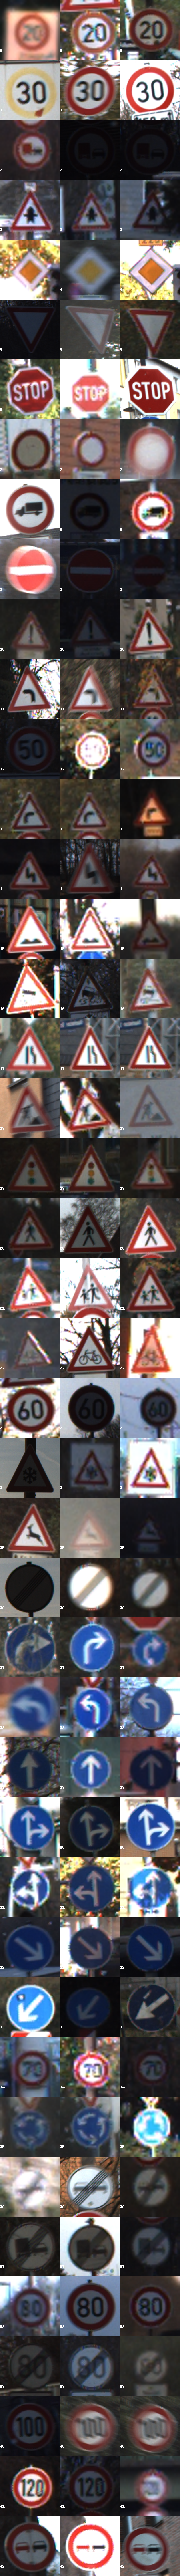

In [70]:
def show_examples_by_class(ds, seed: int = 1234, examples_per_class: int = 4, size=(150, 150)):
    random.seed(seed)  # Set the seed for reproducibility
    w, h = size
    classes = ds['train'].features['label'].names
    classes = sorted(classes, key=lambda x: int(x))
    grid = Image.new('RGB', size=(examples_per_class * w, len(classes) * h))
    draw = ImageDraw.Draw(grid)
    for label_id, label in enumerate(classes):
        class_examples = ds['train'].filter(lambda example: example['label'] == label_id).shuffle(seed=seed).select(range(examples_per_class))
        
        for i, example in enumerate(class_examples):
            image = example['image']
            if not isinstance(image, Image.Image):
                image = Image.fromarray(image)  # Convert to PIL Image if it's not already
            box = (i * w, label_id * h)
            grid.paste(image.resize(size), box=box)
            draw.text((i * w, label_id * h + h - 30), label, (255, 255, 255))
    return grid

show_examples_by_class(split_dataset, seed=random.randint(0, 10000), examples_per_class=3)


In [119]:
id2label = {
    0: 'Speed Limit 20Km/Hr',
    1: 'Speed Limit 30Km⁄Hr',
    2: 'No Passing Of  Vehicle Over 3.5Ton',
    3: 'Crossroads',
    4: 'Priority Road Sign',
    5: 'Yield',
    6: 'Stop',
    7: 'No Vehicles',
    8: 'Vehicle Over 3.5Ton Prohibited',
    9: 'No Entry',
    10: 'General Caution',
    11: 'Dangerous Curve To Left',
    12: 'Speed Limit 50Km⁄Hr',
    13: 'Dangerous Curve To Right',
    14: 'Double Curve',
    15: 'Bumpy Road',
    16: 'Slippery Road',
    17: 'Narrow Road On Right',
    18: 'Road Work',
    19: 'Traffic Sign',
    20: 'Pedestrian',
    21: 'Children Crossing',
    22: 'Bicycle Crossing',
    23: 'Speed Limit 60Km⁄Hr',
    24: 'Beware Of Ice/Snow',
    25: 'Wild Animal Crossing',
    26: 'End Of All Speed And Passing Limit',
    27: 'Compulsory Turn Right',
    28: 'Compulsory Turn Left',
    29: 'Straight Ahead',
    30: 'Go Straight Or Right',
    31: 'Go Straight Or Left',
    32: 'Avoid Obstacle On Right',
    33: 'Avoid Obstacle On Left',
    34: 'Speed Limit 70Km⁄Hr',
    35: 'Roundabout',
    36: 'End Of No Passing',
    37: 'End Of No Passing By Vehicle Over 3.5Ton',
    38: 'Speed Limit 80Km⁄Hr',
    39: 'End Of Speed Limit 80Km/Hr',
    40: 'Speed Limit 100Km⁄Hr',
    41: 'Speed Limit 120Km⁄Hr',
    42: 'No Passing'
}

label2id = {label: id for id, label in id2label.items()}

We can see that the images are varied with respect to size (although we resize them to plot them, we can see some are distorted a bit due to the resizing), color, distance, and sharpness. 

## Set Up Model

For this project I am going to be using the "google/vit-base-patch16-224-in21k" pretrained transformer. The ViTImageProcessor will be used to prepare the data in the format that the model understands, similarly how different tokenizers are used with different NLP models.

In [120]:
from transformers import ViTImageProcessor, ViTForImageClassification

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's take a look at how the processor represents the data. It generates a `pixel_values` tensor of patches (numeric representation of the image), that the model has been pretrained to understand.

In [121]:
processor(split_dataset['train'][123]['image'], return_tensors='pt')

{'pixel_values': tensor([[[[-0.2549, -0.2549, -0.2549,  ..., -0.6627, -0.6627, -0.6627],
          [-0.2549, -0.2549, -0.2549,  ..., -0.6627, -0.6627, -0.6627],
          [-0.2549, -0.2549, -0.2549,  ..., -0.6627, -0.6627, -0.6627],
          ...,
          [-0.1216, -0.1216, -0.1216,  ..., -0.4980, -0.4980, -0.4980],
          [-0.1216, -0.1216, -0.1216,  ..., -0.4980, -0.4980, -0.4980],
          [-0.1216, -0.1216, -0.1216,  ..., -0.4980, -0.4980, -0.4980]],

         [[-0.2314, -0.2314, -0.2314,  ..., -0.6863, -0.6863, -0.6863],
          [-0.2314, -0.2314, -0.2314,  ..., -0.6863, -0.6863, -0.6863],
          [-0.2314, -0.2314, -0.2314,  ..., -0.6863, -0.6863, -0.6863],
          ...,
          [-0.0510, -0.0510, -0.0510,  ..., -0.4980, -0.4980, -0.4980],
          [-0.0510, -0.0510, -0.0510,  ..., -0.4980, -0.4980, -0.4980],
          [-0.0510, -0.0510, -0.0510,  ..., -0.4980, -0.4980, -0.4980]],

         [[-0.2157, -0.2157, -0.2157,  ..., -0.7176, -0.7176, -0.7176],
          [-0

Now, let's apply this preprocessing on all of our training images. I use `with_transform` since it only applies the changes to the data entry once we index it, which saves us time when dealing with such a big dataset as GTSRB.

In [122]:
def process_data(example_batch):
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = example_batch['label']
    return inputs

prepared_split_dataset = split_dataset.with_transform(process_data)

In [124]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [125]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

### Train Model
Now, I use the `transformers` library to instantiate the `TrainingArguments` for this training job, and then use the `Trainer` class to perform the actual training and save the final model. I use `wandb` as a reporting tool so I can follow the training metrics while the job is completing.

In [133]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-traffic-signs",
  per_device_train_batch_size=4,
  evaluation_strategy="steps",
  num_train_epochs=2,
  fp16=False,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='wandb',
  load_best_model_at_end=True,
)

In [134]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_split_dataset["train"],
    eval_dataset=prepared_split_dataset["val"],
    tokenizer=processor,
)

In [ ]:
trainer.train()

### Save Trained Model

In [ ]:
trainer.save_model('./final_model')

### Push Model to HF Hub

In [ ]:
model = ViTForImageClassification.from_pretrained(
    './final_model'
)

model.push_to_hub('cvetanovskaa/vit-base-patch16-224-in21k-gtsrb-tuned')